# Wavelettransformation zur Rauschreduktion in Audiosignalen

Dieser Beleg ist eine Zusammenarbeit von Johannes Müller und Willy Müller. Er wurde für die Hochschule Anhalt, Fachbereich 6 bearbeitet und erstellt. Für den erfolgreichen Abschluss des Moduls Signaltheorie sollte ein tangierendes Thema für einen Beleg ausgesucht werden, welches die Kenntnisse der Studierenden in den gelehrten Themen reflektiert.

## Einleitung und Motivation

Wir haben uns daher gefragt: Inwiefern kann die Wavelettransformation als Mittel zur Reduktion von Hintergrundgeräuschen in Audiosignalen verwendet werden? In der Zeitdomäne ist das sogennante *Ducking* eine häufig verwendete Methode und in der Frequenzdomäne wird oft das Spektrum des Störsignals von dem des Eingangssignals abgezogen. Mit Wavelets könnte eine Kombination dieser Effekte erreicht werden.

Um diese Hypothese zu überprüfen, müssen zuerst die Rahmenbedingungen gesetzt werden.

## Analyse der Problemstellung

Es soll ein System erstellt werden, dass ein zeitdiskretes Eingangssignal $x(t)$ entgegennimmt und ein Signal $y(t)$ ausgibt. Die Amplitude der Signale ist über das Interval $$-1 \leq x \leq 1; -1 \leq y \leq 1$$ begrenzt. Die Diskretisierung in der Zeitachse ist auf die übliche Rate von $\mathsf{sr} = 22050 \ \mathrm{Hz}$ festgelegt, so dass Audiofrequenzen bis ca. $10 \ \mathrm{kHz}$ abgebildet werden können. Die Dauer des Eingangssignals ist in folgeden Tests auf $T = 5 \ \mathrm{s}$ festgelegt, wobei das System dieses Signal in noch kleineren zeitlichen Abschnitten bearbeiten wird und somit auch ein zeitlich unbeschränktes Signal verarbeiten kann.

Das Eingangssignal $x(t)$ setzt sich hier beispielsweise aus dem Nutzsignal $source(t)$ und dem weißen Rauschen $r(t)$ zusammen, wobei das Rauschen nur zu bestimmten Segmenten des Nutzsignals addiert wird.
Zusätzlich zum Eingangssignal $x(t)$ steht dem System das Referenzsample $r(t)$ zur Verfügung, welches zur Bestimmung des Pegels des Störsignals herangezogen werden kann.

In [1]:
# Erzeugung des Störsignals

import numpy
sr = 22050 # sample rate
T = 5.0    # seconds
t = numpy.linspace(0, T, int(T*sr), endpoint=False) # time variable
numpy.random.seed(seed=0xdeadbeef)
r = numpy.random.normal(loc=0, scale=2e-2, size=int(T*sr)) # white noise

from audio import Audio
import librosa
import librosa.display
Audio(r, rate=sr, name="r")

[output/r.wav](output/r.wav)

In [2]:
# Erzeugung des Eingangssignals

def load_source(file):
  source, _ = librosa.load(file, sr=sr, duration=T)
  x = source + r * (numpy.cos(t*2) < 0)
  return x

# Quelle: https://ccrma.stanford.edu/workshops/mir2014/audio/
x = load_source('audio/T39-piano.wav')
Audio(x, rate=sr, name="x")

[output/x.wav](output/x.wav)

## Zeitliche Unterteilung

Das Eingangssignal wird nun in kleinere überlappende Abschnitte unterteilt, welche anschließend zur Rauschminderung weiterverarbeitet werden. Die Länge der Abschnitte so gewählt, dass für die minimalste Frequenz des Signals mindestens eine volle Sinuskurve im Abschnitt enthalten ist. Sie darf aber auch nicht zu lang sein, denn in der Echtzeitverarbeitung müssten alle enthaltenen Werte gepuffert werden, was zusätzliche Latenz herbeibringt. Schließlich sollte sie eine volle Zweierpotenz betragen, um die Abschnitte in optimierten Algorithmen, wie folgend FFT- oder Waveletalgorithmen, effizient verarbeitet zu können. Die Länge der Abschnitte ist hier auf 2048 Sample festgelegt, was einem Zeitinterval von $$\frac{\mathsf{win\_size}}{\mathsf{sr}} = \frac{2048}{22500} = 91.02\ \mathbf{ms}$$ entspricht und somit alle Kriterien ausreichend erfüllt.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

win_size = 2048
stride = win_size >> 1

window = numpy.hanning(win_size)

def signal_to_frames(signal):
    frames = librosa.util.frame(signal, frame_length=win_size, hop_length=stride)
    return numpy.swapaxes(frames, 0, 1)

def frames_to_signal(frames):
    count = len(frames) * stride + win_size
    ret = numpy.ndarray(count)
    ret.fill(0)
    offset = 0
    for frame in frames:
        ret[offset:offset+len(frame)] += frame * window
        offset += stride
    return ret[:int(sr*T)]


Die Abschitte überlappen sich zu 50%. Die nachfolgende Grafik zeigt, wie die überlappenden Abschnitte mit Hilfe der Hanning-Fensterfunktion rekombiniert werden.

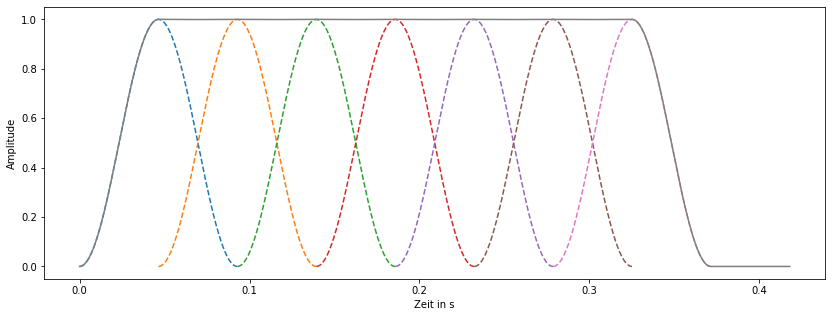

In [4]:
frames = signal_to_frames(numpy.ones(stride*8))
plt.figure(figsize=(14, 5))
plt.xlabel("Zeit in s")
plt.ylabel("Amplitude")
for i, frame in enumerate(frames):
    plt.plot(t[i*stride:i*stride+win_size], frame * window, '--')
plt.plot(t[0:stride*9], frames_to_signal(frames));


## Methoden der Rauschkategorisierung

Die Amplitude des Rauschens im Eingangssignal ist im betrachteten Zeitraum nicht konstant. Jedoch ist die Energie des Rauschens im gesamten Frequenzspektrum des Signals verteilt und kann damit von dem Nutzsignal unterschieden werden. Wenn der Grenzwert zwischen Störsignal und Nutzsignal bekannt ist, dann kommen unabhängig von der Domäne zwei Arten von Grenzwertfunktionen in Betracht:
- Ein harter Filter $f1$, bei dem alle Werte unter einem Grenzwert auf Null gesetzt werden, und
- Ein weicher Filter $f2$, bei dem der Bereich außerhalb des Grenzwertes in Richtung Null skaliert wird.

Diese Filter sind folgend für Werte $arr$ mit dem Grenzwert $g$ mit $0 < g <= max(arr)$ definiert:

In [5]:

# Harter Filter
def f1(arr, g):
    return (abs(arr) >= g) * arr

# Weicher Filter
def f2(arr, g, maximum=1):
    return numpy.sign(arr) * numpy.clip(abs(arr) - g, 0, maximum - g) * (1 / (maximum-g))

## Wahl des Waveletalgorithmus

Für diese Anwendung wurde die *diskrete Wavelettransformation* (DWT) gewählt, denn sie bietet gegenüber der *kontinuierlichen Wavelettransformation* (CWT) Vorteile in der Verarbeitungsgeschwindigkeit und in der Art der erzeugten Koeffizienten.
Während die CWT mit kontinuierlichen Signalen arbeitet, können der DWT direkt die oben erzeugten Abschnitte übergeben werden. Die DWT kann rekursiv angewendet werden, wobei bei der Analyse pro Schritt jeweils $n$ Samples zu $\frac n 2$ niederfrequente Annäherungs- und $\frac n 2$ hochfrequente Detailkoeffizienten erzeugt werden. Die nächsten Schritte werden dann bis einem bestimmten Level auf die Annäherungskoeffizienten des vorherigen Schrittes angewandt.
$$ x = A_1 + D_1 = A_2 + D_2 + D_1 = A_3 + D_3 + D_2 + D_1 $$

Rückwirkend können Abschnitte auch wieder mit Hilfe der Waveletsynthese (iDWT) wiederhergestellt werden.

In [6]:
import pywt

def frames_to_coeffs(frames, wavelet):
    maxlevel = pywt.dwt_max_level(win_size, wavelet)
    return pywt.wavedec(frames, wavelet, level=maxlevel)

def coeffs_to_frames(coeffs, wavelet):
    return pywt.waverec(coeffs, wavelet)

## Wahl des Wavelets

Bei der Wavelettransformation wird wie bei der Konvolution ein bestimmter Filter $\psi(t)$ (das Wavelet) über das Eingangssignal $x(t)$ gelegt.
Durch die zeitliche Verschiebung des Wavelets über dem Signal werden Koeffizienten erzeugt, wessen Charakteristik stark von dem verwendeten Wavelet abhängt. In dieser Anwendung wurde deshalb ein Wavelet gewählt, welches einen geringen akustischen Störeffekt nach der Anwendung des Filters $f2$ hat. Nachfolgend sind auch alternative Kandidaten aufgelistet.

bior1.1 bior1.3 bior1.5 bior2.2 bior2.4 bior2.6 bior2.8 bior3.1 bior3.3 bior3.5 bior3.7 bior3.9 bior4.4 bior5.5 bior6.8 coif1 coif2 coif3 coif4 coif5 coif6 coif7 coif8 coif9 coif10 coif11 coif12 coif13 coif14 coif15 coif16 coif17 db1 db2 db3 db4 db5 db6 db7 db8 db9 db10 db11 db12 db13 db14 db15 db16 db17 db18 db19 db20 db21 db22 db23 db24 db25 db26 db27 db28 db29 db30 db31 db32 db33 db34 db35 db36 db37 db38 dmey haar rbio1.1 rbio1.3 rbio1.5 rbio2.2 rbio2.4 rbio2.6 rbio2.8 rbio3.1 rbio3.3 rbio3.5 rbio3.7 rbio3.9 rbio4.4 rbio5.5 rbio6.8 sym2 sym3 sym4 sym5 sym6 sym7 sym8 sym9 sym10 sym11 sym12 sym13 sym14 sym15 sym16 sym17 sym18 sym19 sym20


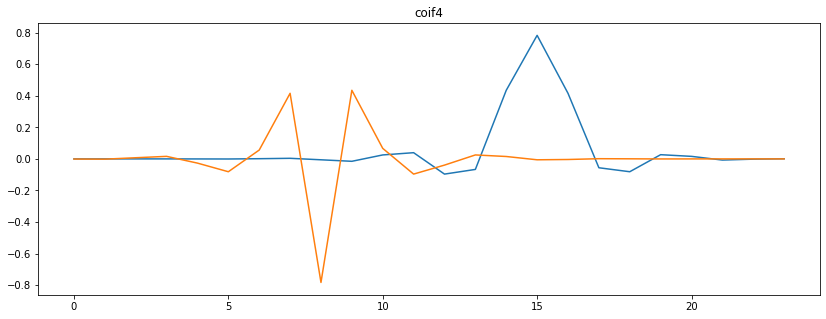

In [7]:

print(' '.join(pywt.wavelist(kind='discrete')))
wavelet = pywt.Wavelet('coif4')
plt.figure(figsize=(14, 5))
plt.title(wavelet.name)
plt.plot(wavelet.dec_lo)
plt.plot(wavelet.dec_hi);

Die so erzeugten Koeffizienten können nun gemäßt der oben definierten Filterfunktion gefiltert werden, um die kleinen Rauschanteile zu unterdrücken. Dazu wird zuerst der Grenzwert des Filters definiert. Dieser setzt sich aus den Maxima der Koeffizienten des Störsignals nach der Wavelettransformation zusammen. Jetzt können alle bereits definierten Teilstücke kombiniert werden, um ein Signal $x(t)$ in seiner Wavelet-transformierten Form zu filtern, um schließlich $y(t)$ als Funktion von $x(t)$, des Wavelets und des Filters zurückzugeben.

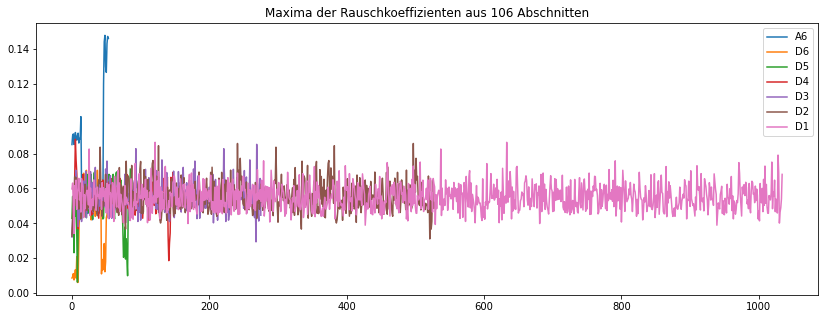

In [8]:
# Koeffizienten des Rauschens bestimmen und Maxima bilden

r_frames = signal_to_frames(r)

def noise_coeffs(wavelet):
    r_coeffs = frames_to_coeffs(r_frames, wavelet)
    for i, coeff in enumerate(r_coeffs):
        r_coeffs[i] = numpy.max(numpy.abs(r_coeffs[i]), axis=0)
    return r_coeffs


plt.figure(figsize=(14, 5))
plt.title(f"Maxima der Rauschkoeffizienten aus {len(r_frames)} Abschnitten")
r_coeffs = noise_coeffs(wavelet)
for i, coeff in enumerate(r_coeffs):
    plt.plot(r_coeffs[i], label=f"A{len(r_coeffs)-1}" if i==0 else f"D{len(r_coeffs)-i}")
plt.legend()

# Filterfunktion konstruieren

def filter_signal(x, wavelet, filter):
    x_frames = signal_to_frames(x)
    r_coeffs = noise_coeffs(wavelet)

    coeffs = frames_to_coeffs(x_frames, wavelet)
    for i, coeff in enumerate(coeffs):
        coeffs[i] = filter(coeff, r_coeffs[i])

    y_frames = coeffs_to_frames(coeffs, wavelet)
    return frames_to_signal(y_frames)

# Anwendung

Nach der Applikation des Filters *f2* auf die Koeffizienten der Wavelettransformation mit *coif4* ist das Rauschen im Ausgangssignal $y(t)$ nicht mehr aufzufinden, jedoch nimmt die Klarheit des Signals drastisch ab. Damit ist Bewiesen, dass mit der aufgeführten Methode tatsächlich das Hintergrundrauschen in Audiosignalen reduziert werden kann; das Resultat ist aber noch nicht optimal.

[output/coif4_f2.wav](output/coif4_f2.wav)

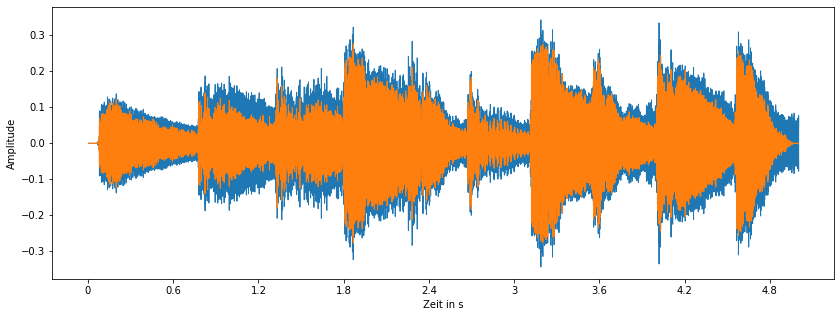

In [9]:
y = filter_signal(x, wavelet, f2)

plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)
librosa.display.waveshow(y, sr=sr)
plt.xlabel("Zeit in s")
plt.ylabel("Amplitude")
Audio(y, rate=sr, name=f"{wavelet.name}_f2")

# Vergleich mit alternativen Filteranwendungen

Nachfolgend wird der Filter *f2* direkt am Eingssignal angewandt. Das Ergebnis ist nicht befriedigend, da das Audiosignal stark gestört wird und der Rauschanteil trotzdem hörbar ist. Die Wavelet-Methode schneidet im Vergleich viel besser ab. 

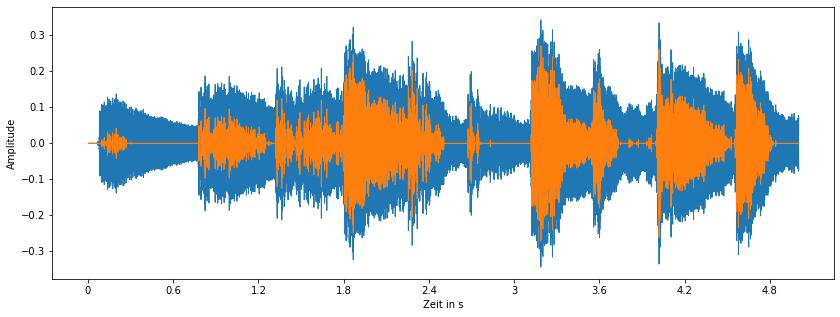

In [10]:
yt = f2(x, 0.1)
Audio(yt, rate=sr, name="t_f2")

plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)
librosa.display.waveshow(yt, sr=sr)
plt.xlabel("Zeit in s")
plt.ylabel("Amplitude");

Hier wird der Filter auf die Koeffizienten nach der Fouriertransformation der Abschnitte angewandt. Bei dem Piano-Eingangssignal schneidet die Rauschentfernung via *Short-time Fourier transform* (STFT) subjektiv besser ab als die Wavelet-Methode. Obwohl hier auch ein paar hohe Störfrequenzen übrig bleiben, kann das auf seine Grundfrequenz und deren Obertöne reduzierte Instrument besser wahrgenommen werden. 

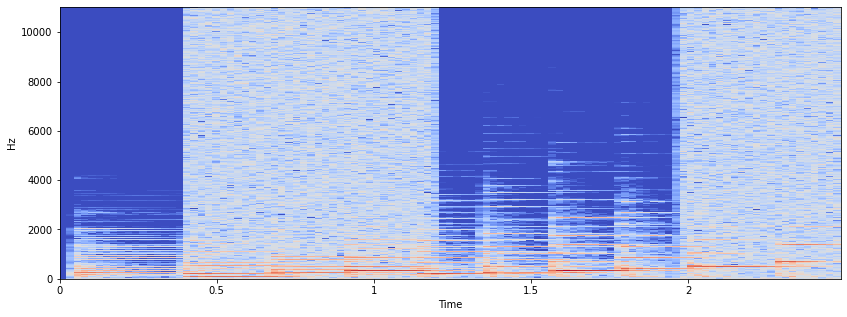

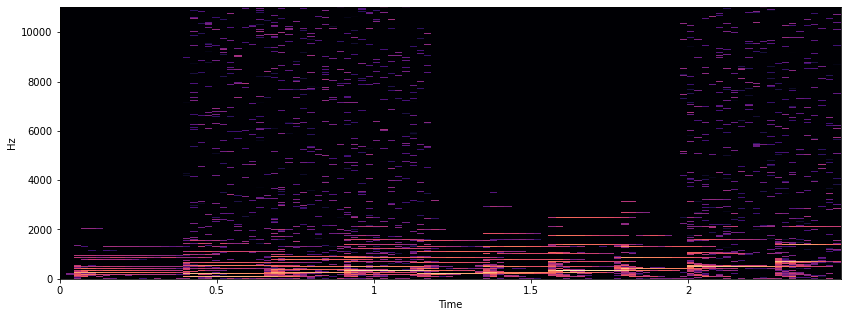

In [11]:
X = librosa.stft(x, n_fft=win_size, hop_length=stride)
Y = f2(abs(X), 0.9, numpy.max(abs(X))) * numpy.exp(1j * numpy.angle(X))

y = librosa.istft(Y, hop_length=stride)
y = y * max(x) / max(y)


Xdb = librosa.amplitude_to_db(abs(X))
Ydb = librosa.amplitude_to_db(abs(Y))

plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.figure(figsize=(14, 5))

librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='hz');

In der hier dargestellten Frequenzdomäne kann man deutlich den Effekt des Filters *f2* erkennen. Der breitbandige Rauschanteil ist visuell kaum mehr erkennbar.
Folgend ist der Amplitudenverlauf und das Ergebnis der STFT-Filterung aufgelistet.

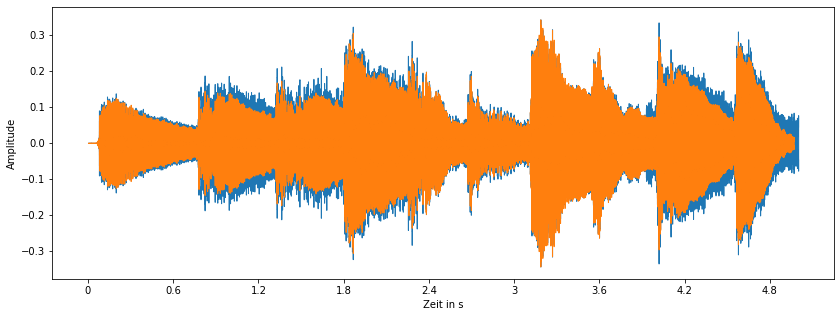

In [12]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)
librosa.display.waveshow(y, sr=sr)
plt.xlabel("Zeit in s")
plt.ylabel("Amplitude");

In [13]:
Audio(y, rate=sr, name="stft_f2")

[output/stft_f2.wav](output/stft_f2.wav)

Zum Abschluss sind noch einmal die Wavelet- und STFT-Algorithmen für ein Sprachsignal implementiert.

Quelle: https://commons.wikimedia.org/wiki/File:Frase_de_Neil_Armstrong.ogg

In [14]:
voice_x = load_source("audio/Frase_de_Neil_Armstrong.ogg")
Audio(voice_x, rate=sr, name="voice")

[output/voice.wav](output/voice.wav)

In [15]:
voice_y = filter_signal(voice_x, wavelet, f2)
Audio(voice_y, rate=sr, name=f"voice_{wavelet.name}_f2")

[output/voice_coif4_f2.wav](output/voice_coif4_f2.wav)

In [16]:
voice_X = librosa.stft(voice_x, n_fft=win_size, hop_length=stride)
voice_Y = f2(abs(voice_X), 0.9, numpy.max(abs(voice_X))) * numpy.exp(1j * numpy.angle(voice_X))

voice_stft = librosa.istft(voice_Y, hop_length=stride)
voice_stft = voice_stft * max(voice_x) / max(voice_stft)

Audio(voice_stft, rate=sr, name="voice_stft_f2")

[output/voice_stft_f2.wav](output/voice_stft_f2.wav)